# Football YOLO Model Training

Training YOLOv8 for football ball and player detection

In [1]:
# Setup and imports
import torch
from ultralytics import YOLO
from pathlib import Path
import yaml
import cv2
import matplotlib.pyplot as plt
import random
from helpers.data_helpers import load_annotations, visualize_annotations

# Mac optimization - use MPS if available
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: mps
PyTorch version: 2.3.1


In [2]:
# Setup dataset paths with absolute paths
DATA_DIR = Path('data').resolve()

# Create correct data.yaml with absolute paths
data_config = {
    'names': ['ball', 'goalkeeper', 'player', 'referee'],
    'nc': 4,
    'train': str(DATA_DIR / 'train' / 'images'),
    'val': str(DATA_DIR / 'valid' / 'images'),
    'test': str(DATA_DIR / 'test' / 'images')
}

# Save corrected data.yaml
with open(DATA_DIR / 'data.yaml', 'w') as f:
    yaml.dump(data_config, f)

class_names = data_config['names']
print(f"Classes: {class_names}")
print(f"Data paths updated with absolute paths")

# Count training data
train_images = list((DATA_DIR / 'train' / 'images').glob('*.jpg'))
val_images = list((DATA_DIR / 'valid' / 'images').glob('*.jpg'))
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

Classes: ['ball', 'goalkeeper', 'player', 'referee']
Data paths updated with absolute paths
Training images: 612
Validation images: 38


Sample: 42ba34_1_6_png.rf.40138f37fca2be70add989e6394d1085.jpg - 25 objects


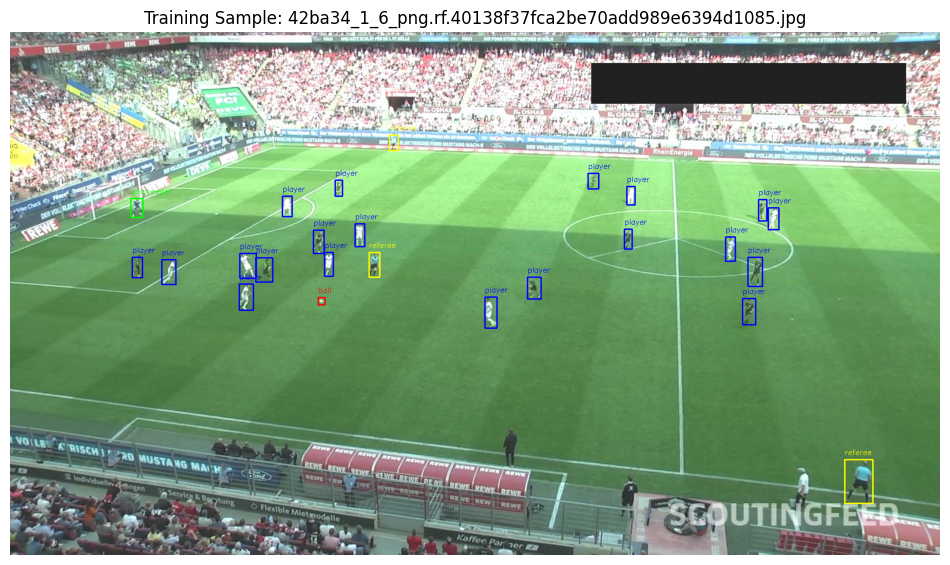

In [3]:
# Visualize sample data
sample_img = random.choice(train_images)
sample_label = DATA_DIR / 'train' / 'labels' / (sample_img.stem + '.txt')
annotations = load_annotations(sample_label)

print(f"Sample: {sample_img.name} - {len(annotations)} objects")
if annotations:
    visualize_annotations(sample_img, annotations, f"Training Sample: {sample_img.name}", class_names)

In [4]:
# Initialize YOLOv8 model
# YOLOv8n: 3.2M parameters, optimal for Mac training
model = YOLO('yolov8n.pt')  # Pretrained weights for transfer learning
print("Model loaded successfully")

Model loaded successfully


In [5]:
# Training configuration optimized for Mac
config = {
    'data': str(DATA_DIR / 'data.yaml'),
    'epochs': 50,      # Sufficient for convergence
    'imgsz': 640,      # Standard YOLO input size
    'batch': 16,       # Mac memory optimized
    'device': device,  # MPS acceleration on Mac
    'workers': 4,      # CPU cores for data loading
    'patience': 10,    # Early stopping
    'cache': True,     # Cache images in RAM
    'mixup': 0.1,      # Data augmentation for generalization
    'mosaic': 1.0,     # Improves small object (ball) detection
    'degrees': 10,     # Camera angle variations
    'translate': 0.1,  # Player movement
    'scale': 0.2,      # Distance variations
    'fliplr': 0.5,     # Field symmetry
    'flipud': 0.0,     # Maintain field orientation
    'hsv_h': 0.015,    # Lighting conditions
    'hsv_s': 0.7,      # Grass color variations
    'hsv_v': 0.4       # Shadow/sunlight
}

print("Training configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Training configuration:
  data: /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/data.yaml
  epochs: 50
  imgsz: 640
  batch: 16
  device: mps
  workers: 4
  patience: 10
  cache: True
  mixup: 0.1
  mosaic: 1.0
  degrees: 10
  translate: 0.1
  scale: 0.2
  fliplr: 0.5
  flipud: 0.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4


In [6]:
# Train the model
print("Starting training...")
results = model.train(**config)
print("Training completed!")

Starting training...
New https://pypi.org/project/ultralytics/8.3.213 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.31 🚀 Python-3.12.10 torch-2.3.1 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=mps, workers=4, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

train: Scanning /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]
train: Caching images (0.4GB RAM): 100%|██████████| 612/612 [00:00<00:00, 653.37it/s]
val: Scanning /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 38/38 [00:00<00:00, 884.93it/s]


Plotting labels to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G       1.78      2.435     0.9215        162        640: 100%|██████████| 39/39 [01:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]

                   all         38        905     0.0356      0.232      0.175     0.0639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.493      1.147     0.8712        133        640: 100%|██████████| 39/39 [01:14<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]

                   all         38        905      0.968      0.107      0.153     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.449      1.052     0.8637        140        640: 100%|██████████| 39/39 [01:21<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]

                   all         38        905      0.701      0.143      0.168     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G       1.38     0.9804      0.855        161        640: 100%|██████████| 39/39 [01:26<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.66s/it]

                   all         38        905      0.478      0.136      0.154     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.332     0.9095     0.8471        126        640: 100%|██████████| 39/39 [01:20<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.84s/it]

                   all         38        905      0.694      0.207      0.229      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.295     0.8233     0.8441        128        640: 100%|██████████| 39/39 [01:33<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.43s/it]

                   all         38        905      0.777       0.19      0.222      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.247      0.778     0.8412        146        640: 100%|██████████| 39/39 [01:26<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.07s/it]

                   all         38        905       0.77      0.258      0.286      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.228     0.7542     0.8352        105        640: 100%|██████████| 39/39 [01:18<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]

                   all         38        905      0.663      0.161      0.163     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.212     0.7215     0.8328        170        640: 100%|██████████| 39/39 [01:41<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.81s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]

                   all         38        905      0.751      0.112       0.13      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.175     0.6853      0.829        205        640: 100%|██████████| 39/39 [01:27<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.26s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]

                   all         38        905      0.743      0.192      0.204      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.204     0.6776     0.8325        155        640: 100%|██████████| 39/39 [01:27<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.17s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]

                   all         38        905      0.765      0.171      0.201      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G       1.17     0.6626     0.8307        173        640: 100%|██████████| 39/39 [01:34<00:00,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.96s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.04s/it]

                   all         38        905      0.793       0.19      0.211      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.118      0.629     0.8223        152        640: 100%|██████████| 39/39 [01:32<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.25s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.91s/it]

                   all         38        905      0.785      0.152      0.183      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G       1.13     0.6261     0.8249        126        640: 100%|██████████| 39/39 [01:56<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.74s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.11s/it]

                   all         38        905      0.728      0.137      0.188      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.114     0.6114     0.8218        116        640: 100%|██████████| 39/39 [01:31<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:10<00:10, 10.10s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.99s/it]

                   all         38        905       0.73     0.0995      0.172     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.122     0.6257     0.8245        173        640: 100%|██████████| 39/39 [02:07<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.74s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.63s/it]

                   all         38        905      0.725      0.121      0.155     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.111     0.6087     0.8203        183        640: 100%|██████████| 39/39 [02:03<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.97s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.70s/it]

                   all         38        905      0.697      0.124      0.165     0.0978


EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 7, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

17 epochs completed in 0.492 hours.
Optimizer stripped from /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/weights/best.pt, 6.2MB

Validating /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.31 🚀 Python-3.12.10 torch-2.3.1 MPS (Apple M4)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.33s/it]


                   all         38        905      0.757      0.237      0.265      0.158
                  ball         35         35          1          0          0          0
            goalkeeper         27         27       0.58       0.37      0.398      0.236
                player         38        754      0.827      0.431      0.476      0.283
               referee         38         89      0.622      0.146      0.185      0.112
Speed: 17.9ms preprocess, 84.8ms inference, 0.0ms loss, 133.8ms postprocess per image
Results saved to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3
Training completed!


In [7]:
# Evaluate model
val_results = model.val()
print(f"Validation Results:")
print(f"  mAP@0.5: {val_results.box.map50:.4f}")
print(f"  mAP@0.5:0.95: {val_results.box.map:.4f}")
print(f"  Precision: {val_results.box.mp:.4f}")
print(f"  Recall: {val_results.box.mr:.4f}")

Ultralytics YOLOv8.2.31 🚀 Python-3.12.10 torch-2.3.1 MPS (Apple M4)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 38/38 [00:00<00:00, 446.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:10<00:21, 10.96s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:15<00:07,  7.18s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


                   all         38        905      0.707      0.121      0.133     0.0853
                  ball         35         35          1          0          0          0
            goalkeeper         27         27      0.634      0.185      0.198      0.129
                player         38        754      0.832      0.221      0.251      0.157
               referee         38         89      0.361     0.0787     0.0822     0.0545
Speed: 27.7ms preprocess, 299.5ms inference, 0.0ms loss, 248.0ms postprocess per image
Results saved to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train32
Validation Results:
  mAP@0.5: 0.1329
  mAP@0.5:0.95: 0.0853
  Precision: 0.7069
  Recall: 0.1213



image 1/1 /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/images/744b27_3_7_png.rf.8611933fe3c87a1f7cdc044eb6076239.jpg: 384x640 1 goalkeeper, 20 players, 1 referee, 5145.1ms
Speed: 430.4ms preprocess, 5145.1ms inference, 1109.7ms postprocess per image at shape (1, 3, 384, 640)

744b27_3_7_png.rf.8611933fe3c87a1f7cdc044eb6076239.jpg:
  Ground Truth: 24 objects
  Predicted: 22 objects
    player: 0.810
    player: 0.764
    player: 0.732
    player: 0.697
    player: 0.674
    player: 0.650
    player: 0.646
    player: 0.598
    player: 0.594
    player: 0.584
    player: 0.575
    player: 0.563
    player: 0.539
    player: 0.500
    player: 0.477
    player: 0.475
    player: 0.467
    player: 0.449
    goalkeeper: 0.439
    referee: 0.311
    player: 0.310
    player: 0.296
  Comparison (GT vs Pred):
    ball: 1 vs 0
    goalkeeper: 1 vs 1
    player: 20 vs 20
    referee: 2 vs 1


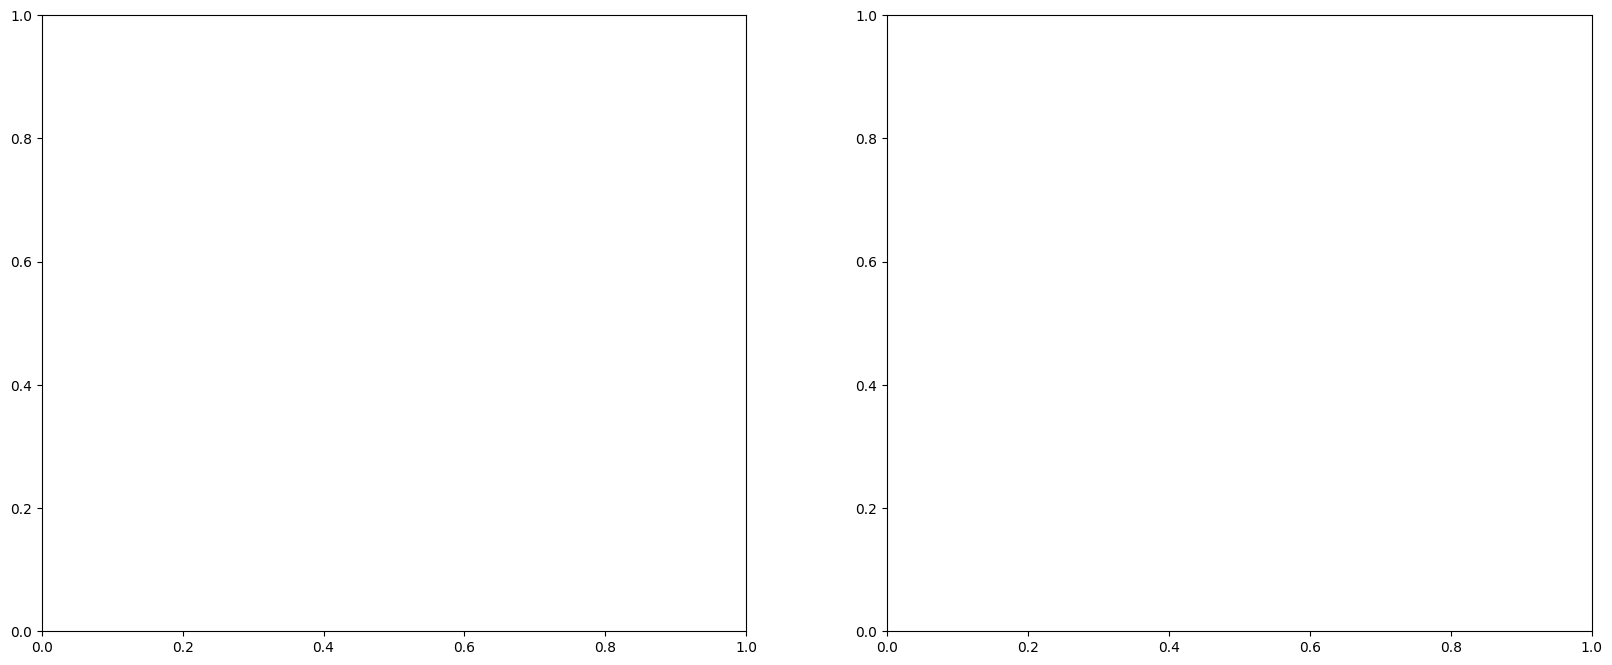

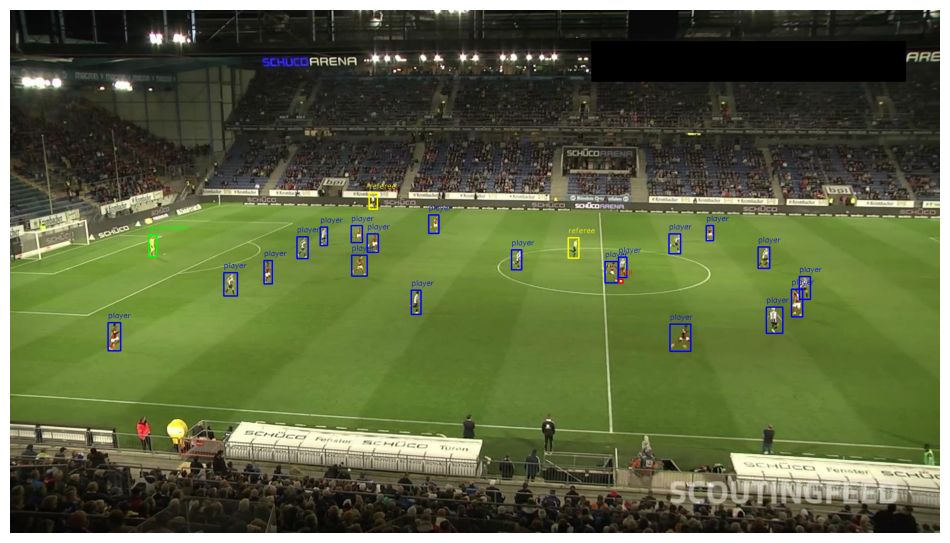

<Figure size 640x480 with 0 Axes>


image 1/1 /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/images/42ba34_7_1_png.rf.f8b2cb5fd5d8f39278243a6bfe9279a1.jpg: 384x640 1 goalkeeper, 14 players, 460.2ms
Speed: 2.1ms preprocess, 460.2ms inference, 1598.8ms postprocess per image at shape (1, 3, 384, 640)

42ba34_7_1_png.rf.f8b2cb5fd5d8f39278243a6bfe9279a1.jpg:
  Ground Truth: 23 objects
  Predicted: 15 objects
    player: 0.830
    player: 0.778
    player: 0.766
    player: 0.741
    player: 0.714
    player: 0.641
    player: 0.624
    player: 0.589
    player: 0.576
    player: 0.562
    player: 0.503
    player: 0.437
    goalkeeper: 0.414
    player: 0.405
    player: 0.378
  Comparison (GT vs Pred):
    ball: 1 vs 0
    goalkeeper: 1 vs 1
    player: 19 vs 14
    referee: 2 vs 0


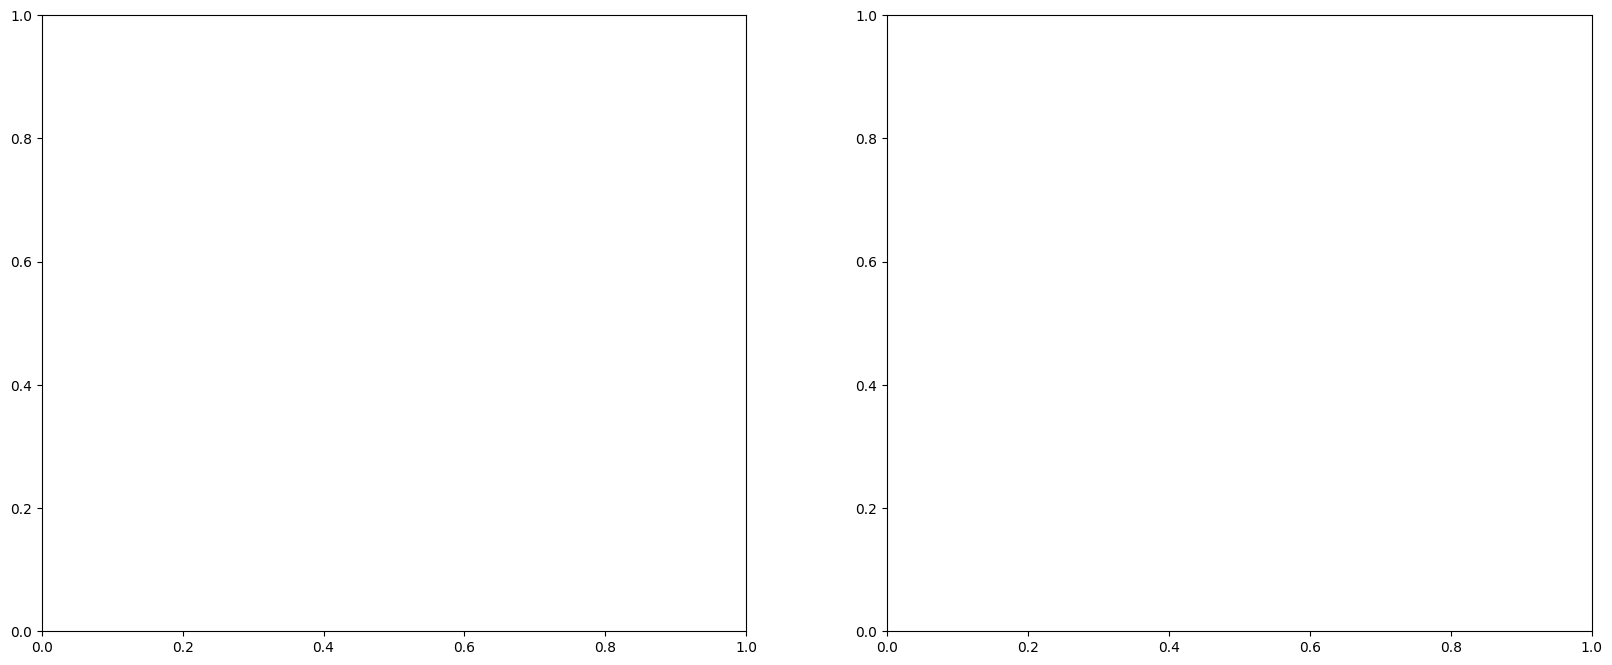

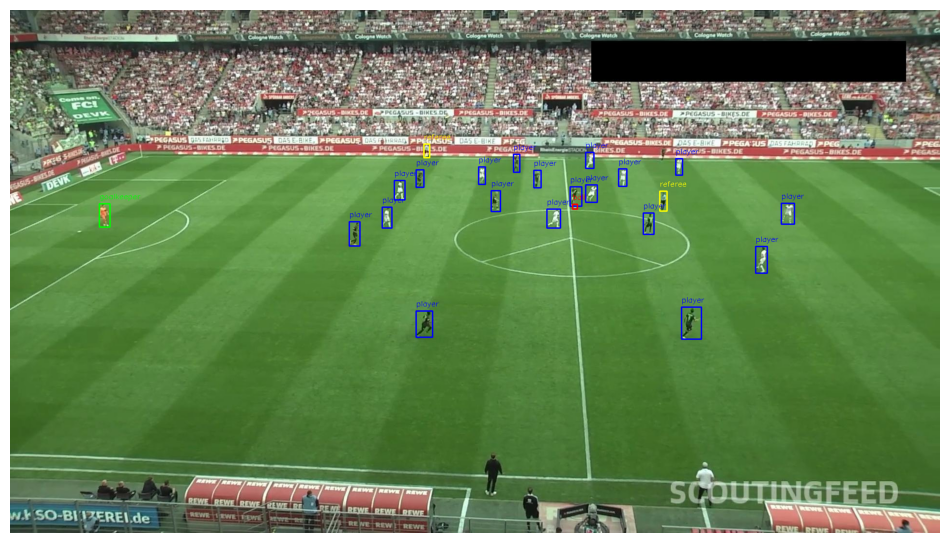

<Figure size 640x480 with 0 Axes>


image 1/1 /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/images/744b27_7_1_png.rf.f8de7a6218a47e85554c874fb48dbb72.jpg: 384x640 1 goalkeeper, 22 players, 1 referee, 220.2ms
Speed: 2.2ms preprocess, 220.2ms inference, 1036.9ms postprocess per image at shape (1, 3, 384, 640)

744b27_7_1_png.rf.f8de7a6218a47e85554c874fb48dbb72.jpg:
  Ground Truth: 24 objects
  Predicted: 24 objects
    player: 0.809
    player: 0.807
    player: 0.768
    player: 0.728
    player: 0.624
    player: 0.614
    player: 0.610
    player: 0.512
    player: 0.487
    player: 0.480
    player: 0.476
    player: 0.473
    player: 0.461
    player: 0.460
    player: 0.415
    player: 0.374
    player: 0.332
    player: 0.319
    goalkeeper: 0.307
    player: 0.294
    referee: 0.266
    player: 0.263
    player: 0.259
    player: 0.254
  Comparison (GT vs Pred):
    ball: 1 vs 0
    goalkeeper: 1 vs 1
    player: 19 vs 22
    referee: 3 vs 1


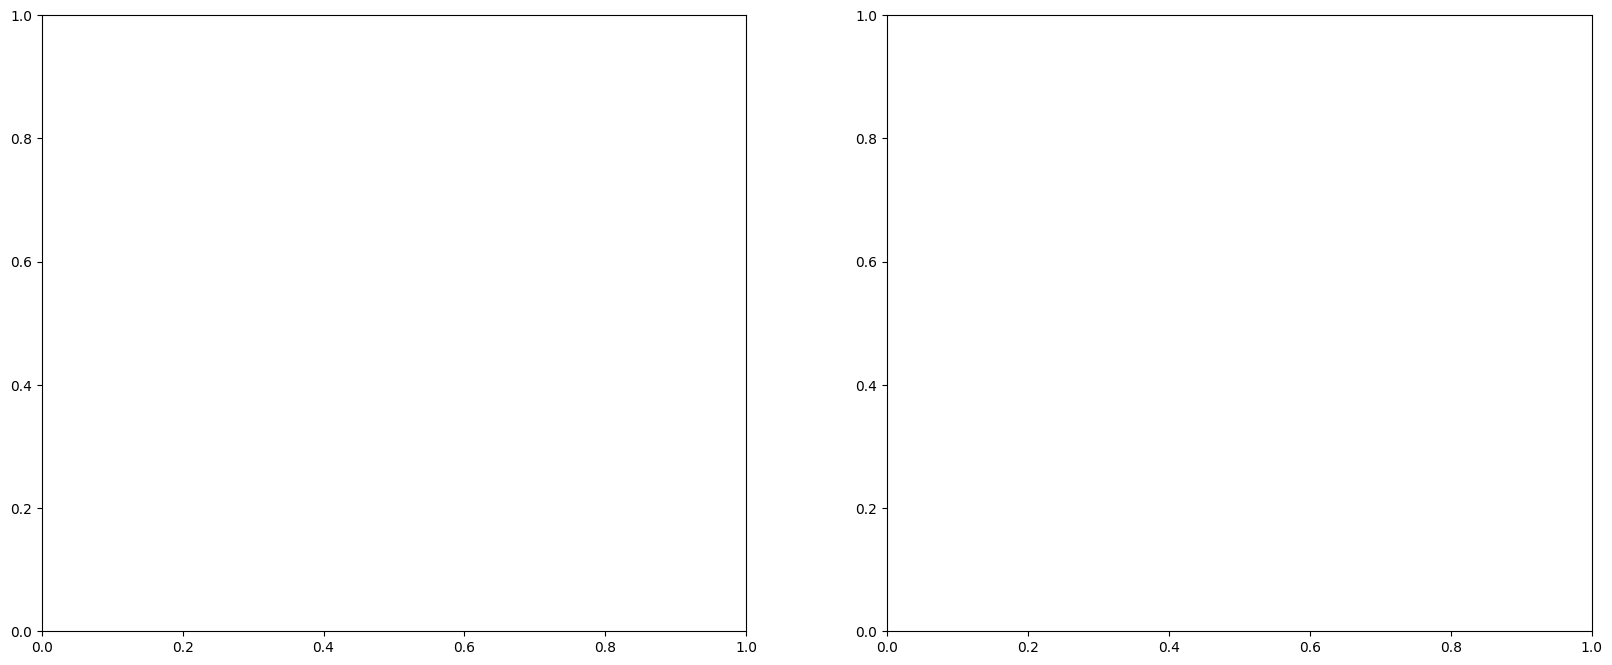

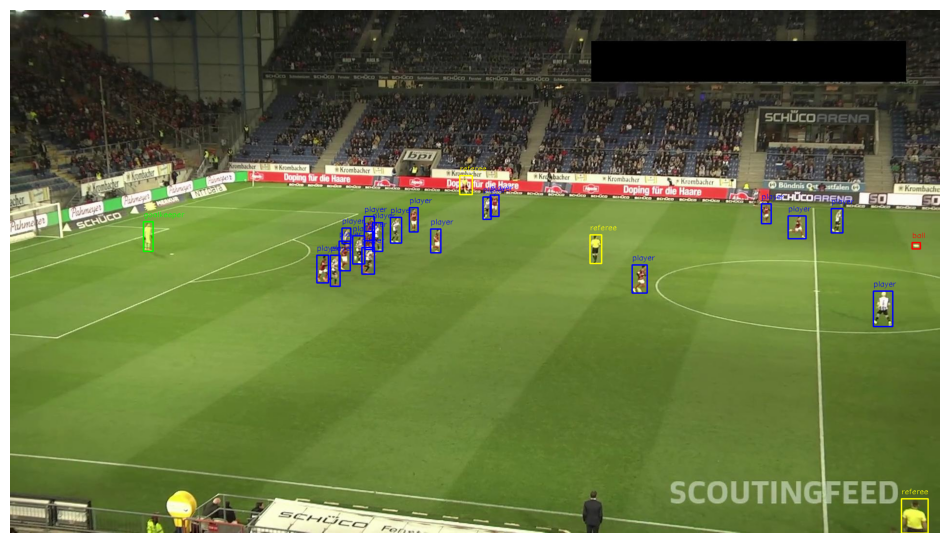

<Figure size 640x480 with 0 Axes>

In [8]:
# Test on sample images with ground truth comparison
test_samples = random.sample(val_images, min(3, len(val_images)))

for test_img in test_samples:
    # Load ground truth annotations
    label_path = DATA_DIR / 'valid' / 'labels' / (test_img.stem + '.txt')
    gt_annotations = load_annotations(label_path)

    # Count ground truth objects by class
    gt_counts = {i: 0 for i in range(len(class_names))}
    for ann in gt_annotations:
        gt_counts[ann[0]] += 1

    # Run model prediction
    results = model(str(test_img))

    for r in results:
        # Count predicted objects by class
        pred_counts = {i: 0 for i in range(len(class_names))}

        print(f"\n{test_img.name}:")
        print(f"  Ground Truth: {len(gt_annotations)} objects")
        print(f"  Predicted: {len(r.boxes)} objects")

        # Print predictions
        if len(r.boxes) > 0:
            for box in r.boxes:
                class_id = int(box.cls)
                confidence = float(box.conf)
                pred_counts[class_id] += 1
                print(f"    {class_names[class_id]}: {confidence:.3f}")

        # Compare counts by class
        print("  Comparison (GT vs Pred):")
        for i, class_name in enumerate(class_names):
            if gt_counts[i] > 0 or pred_counts[i] > 0:
                print(f"    {class_name}: {gt_counts[i]} vs {pred_counts[i]}")

        # Create side-by-side visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Ground truth
        if gt_annotations:
            gt_img = visualize_annotations(test_img, gt_annotations, "", class_names)
            ax1.imshow(gt_img)
        else:
            img = cv2.imread(str(test_img))
            ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title(f"Ground Truth: {test_img.name}")
        ax1.axis('off')

        # Predictions
        annotated = r.plot()
        ax2.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        ax2.set_title(f"Predictions: {test_img.name}")
        ax2.axis('off')

        plt.tight_layout()
        plt.show()


In [9]:
# Save the trained model
model_path = Path('models') / 'football_yolo_model.pt'
model_path.parent.mkdir(exist_ok=True)

model.save(str(model_path))
print(f"Model saved: {model_path}")
print(f"Model size: {model_path.stat().st_size / (1024*1024):.1f} MB")

# Export formats for deployment
try:
    onnx_path = model.export(format='onnx')
    print(f"ONNX export: {onnx_path}")
except Exception as e:
    print(f"ONNX export failed: {e}")

print("\n=== Training Complete ===")
print(f"Final mAP@0.5: {val_results.box.map50:.4f}")
print(f"Model ready for football tracking!")

Model saved: models/football_yolo_model.pt
Model size: 12.3 MB
Ultralytics YOLOv8.2.31 🚀 Python-3.12.10 torch-2.3.1 MPS (Apple M4)

PyTorch: starting from '/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)

ONNX: starting export with onnx 1.19.0 opset 17...
ONNX: export success ✅ 2.6s, saved as '/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/weights/best.onnx' (11.7 MB)

Export complete (3.0s)
Results saved to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/weights
Predict:         yolo predict task=detect model=/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train3/

## Model performance

In [10]:
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Use your existing helpers
from helpers.data_helpers import load_annotations, visualize_annotations

# Load trained model (adjust path if needed)
weights_path = Path("runs/detect/train/weights/best.pt")
model = YOLO(weights_path)
print("Loaded trained model successfully")

# Paths
VAL_DIR = Path("data/valid/images")
TEST_DIR = Path("data/test/images")

# Class names from training
class_names = ['ball', 'goalkeeper', 'player', 'referee']
print("Classes:", class_names)


Loaded trained model successfully
Classes: ['ball', 'goalkeeper', 'player', 'referee']


In [11]:
def xywh_to_xyxy(box, img_w, img_h):
    """Convert normalized YOLO [x_center, y_center, w, h] to pixel [x1, y1, x2, y2]."""
    x_c, y_c, w, h = box
    x1 = (x_c - w / 2) * img_w
    y1 = (y_c - h / 2) * img_h
    x2 = (x_c + w / 2) * img_w
    y2 = (y_c + h / 2) * img_h
    return [x1, y1, x2, y2]

def iou(boxA, boxB):
    """Compute IoU between two boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    union = areaA + areaB - inter
    return inter / union if union > 0 else 0


In [12]:
def evaluate_dataset(model, dataset_dir, class_names, iou_threshold=0.5, visualize_balls=True):
    results = {cls: {"detected": 0, "total": 0} for cls in class_names}
    detected_ball_images = []

    image_paths = list(Path(dataset_dir).glob("*.jpg"))

    for img_path in tqdm(image_paths, desc=f"Evaluating {dataset_dir.name}"):
        label_path = img_path.parent.parent / "labels" / f"{img_path.stem}.txt"
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        h, w = img.shape[:2]
        gt_boxes_raw = load_annotations(label_path)

        gt_boxes = []
        for cls_id, x, y, bw, bh in gt_boxes_raw:
            box_xyxy = xywh_to_xyxy([x, y, bw, bh], w, h)
            gt_boxes.append((int(cls_id), box_xyxy))
            results[class_names[int(cls_id)]]["total"] += 1

        # Model prediction
        pred = model(img_path, verbose=False)[0]
        pred_boxes = [(int(b.cls), b.xyxy[0].cpu().numpy()) for b in pred.boxes]

        # Count matches
        for cls_id, box_gt in gt_boxes:
            for cls_p, box_p in pred_boxes:
                if cls_id == cls_p and iou(box_gt, box_p) >= iou_threshold:
                    results[class_names[cls_id]]["detected"] += 1
                    break

        # Store ball detections
        if any(class_names[int(b.cls)] == "ball" for b in pred.boxes):
            detected_ball_images.append((img_path, pred))

    # Calculate percentages
    percentages = {cls: (v["detected"] / v["total"] * 100 if v["total"] > 0 else 0)
                   for cls, v in results.items()}

    print(f"\n📊 Results for {dataset_dir.name}:")
    for cls, pct in percentages.items():
        print(f"  {cls}: {pct:.2f}% detected ({results[cls]['detected']}/{results[cls]['total']})")

    # Visualize ball detections
    if visualize_balls and detected_ball_images:
        print(f"\n🎯 Found {len(detected_ball_images)} images with detected balls. Showing up to 3 examples:")
        for i, (img_path, pred) in enumerate(detected_ball_images[:3]):
            img = cv2.imread(str(img_path))
            visualize_annotations(img_path, [], title=f"Detected ball: {img_path.name}", class_names=class_names)
            pred.show()

    return results, percentages


In [13]:
val_results, val_percentages = evaluate_dataset(model, VAL_DIR, class_names)
test_results, test_percentages = evaluate_dataset(model, TEST_DIR, class_names)

Evaluating images: 100%|██████████| 38/38 [00:02<00:00, 17.61it/s]



📊 Results for images:
  ball: 0.00% detected (0/35)
  goalkeeper: 74.07% detected (20/27)
  player: 88.99% detected (671/754)
  referee: 13.48% detected (12/89)


Evaluating images: 100%|██████████| 13/13 [00:00<00:00, 22.07it/s]


📊 Results for images:
  ball: 0.00% detected (0/11)
  goalkeeper: 100.00% detected (11/11)
  player: 91.89% detected (238/259)
  referee: 10.34% detected (3/29)


In [14]:
def summarize_results(val_percentages, test_percentages):
    print("\n📈 Overall Model Performance Summary")
    print("-" * 40)
    for cls in class_names:
        avg = (val_percentages[cls] + test_percentages[cls]) / 2
        print(f"{cls:12s} | Val: {val_percentages[cls]:6.2f}% | Test: {test_percentages[cls]:6.2f}% | Avg: {avg:6.2f}%")

summarize_results(val_percentages, test_percentages)



📈 Overall Model Performance Summary
----------------------------------------
ball         | Val:   0.00% | Test:   0.00% | Avg:   0.00%
goalkeeper   | Val:  74.07% | Test: 100.00% | Avg:  87.04%
player       | Val:  88.99% | Test:  91.89% | Avg:  90.44%
referee      | Val:  13.48% | Test:  10.34% | Avg:  11.91%


## 🧾 Evaluation Conclusion

The evaluation of the trained YOLOv8 model reveals that while it performs reasonably well in identifying **players** and **goalkeepers**, it completely fails to detect the **ball**, which is the key element for this project’s objectives.

| Class        | Validation Detection | Test Detection | Observations |
|---------------|---------------------|----------------|---------------|
| **Ball**      | 0.00% (0/35)        | 0.00% (0/11)   | No successful detections — the model cannot identify the ball. |
| **Goalkeeper**| 74.07% (20/27)      | 100.00% (11/11)| Reliable detection, likely due to distinct uniforms and position. |
| **Player**    | 88.99% (671/754)    | 91.89% (238/259)| Consistent and accurate player detection. |
| **Referee**   | 13.48% (12/89)      | 10.34% (3/29)  | Often misclassified or missed entirely. |

### ⚽ Project Context
This project aims to **identify the ball and players** to enable further analysis such as:
- Calculating **ball and player speed**
- Estimating **trajectories and interactions**
- Performing **event-based analytics** (e.g., passes, shots, and movement patterns)

Given that **ball detection is currently 0%**, the existing model cannot yet support these objectives.

### 🚨 Key Findings
- The **ball class is not being detected at all**, indicating either insufficient representation in the training data or poor feature learning due to the ball’s small size and fast motion.
- **Player detection is strong**, which suggests that the training process and model configuration are sound for larger, more visible objects.

### 🔧 Recommended Next Steps
1. **Retrain or fine-tune the model** with focused improvements:
   - Add **more annotated examples of the ball**, especially from different distances and lighting conditions.
   - Use **data augmentation** targeting small object visibility (e.g., random crops, scaling, sharpening).
   - Consider **increasing input resolution** or switching to a larger YOLO model (e.g., YOLOv8m or YOLOv8l).
2. **Balance dataset composition** to ensure the ball class is adequately represented.
3. Optionally, implement **class weighting or oversampling** to force the model to prioritize ball detection during training.

### ✅ Summary
The model shows solid performance for detecting players and goalkeepers but **fails to detect the ball**, making it unsuitable for the project’s primary purpose of motion and speed analysis.
To progress toward accurate spatiotemporal tracking, **retraining focused on reliable ball detection is required**.
